### Libraries

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_selection import RFE

### Reading Data

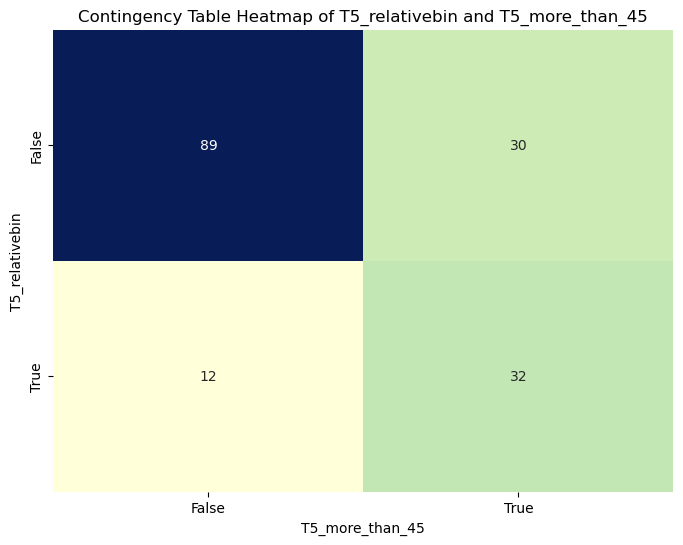

In [3]:
# Load the new voorspelers file with semicolon separator
voorspellers_df = pd.read_csv('../Export/Voorspellers.csv', delimiter=';')

# Load the uitkomstmaat data_clean_cleanset
uitkomstmaat_df = pd.read_csv('../Export/uitkomstmaat.csv', delimiter=';')
uitkomstmaat_vars = uitkomstmaat_df[["patientnummer", "T0", "T5"]]

ML_df = pd.merge(voorspellers_df, uitkomstmaat_vars, left_on='Participant Id', right_on='patientnummer', how='inner')
ML_df.drop(columns=['Participant Id', 'patientnummer'], inplace=True)
ML_df['T5_relative'] = ML_df['T5']/ML_df['T0']
ML_df['T5_relativebin'] = ML_df['T5_relative'] >= 1

ML_df['T5_more_than_45'] = ML_df['T5'] > 45
ML_df['T5_recovered'] = (ML_df['T5_relativebin']) & (ML_df['T5_more_than_45'])

import seaborn as sns
import matplotlib.pyplot as plt

# Create a contingency table
contingency_table = pd.crosstab(ML_df['T5_relativebin'], ML_df['T5_more_than_45'])

# Plot the contingency table as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Contingency Table Heatmap of T5_relativebin and T5_more_than_45')
plt.xlabel('T5_more_than_45')
plt.ylabel('T5_relativebin')
plt.show()

In [4]:
# Calculate the number of people below 0.9 and above 0.9
below_count = ML_df[ML_df['T5_relative'] < 1].shape[0]
above_count = ML_df[ML_df['T5_relative'] >= 1].shape[0]

print(f"Number of people with T5_relative below 1: {below_count}")
print(f"Number of people with T5_relative 1 or above: {above_count}")

Number of people with T5_relative below 1: 61
Number of people with T5_relative 1 or above: 44


### Imputing Data

In [8]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume ML_df is your DataFrame
# data_clean is data met Imputation
# data is data zonder imputation
data_clean = ML_df.copy()
data = ML_df.copy()

# Identify columns
continuous_columns = [
    'T0_age', 'T0_BMI', 'T0_BIA_VVM_kg', 'T0_BIA_vetmassa_kg', 
    'Time_pretreat_OK', 'OK_Duration_min', 'Length_of_stay', 
    'T0_30SCST', 'T0_fatigue', 'T0_protein_perc', 'T0_kcal_perc', 
    'T0_CT_SMI', 'T0_CT_SMRA', 't0_gses_totaal_score', 
    'T0_participation_ability', 'T0_participation_satisfaction', 
    't0_EQ_5D_5L_beschrijvend-systeem_score', 'T0_pain', 'T0'
]

categorical_columns = [
    'T0_VVMI_per', 'Education', 'household', 'T0_Tumorsize', 
    'T0_diseaseburden_cat', 'T0_selfcare', 'T0_Locusofcontrol_cat',
    'T0_socialsupport_cat', 'T0_coping_cat', 'AMEXO_8_day1', 
    'AMEXO_9_day2', 'AMEXO_10_day3', 'T0_sondevoeding', 'T0_protein_cat',
    'T0_kcal_cat', 'T0_ASM_low', 'T0_anxiety_cat', 'T0_depression_cat'
]

# Remove rows with missing values in T5
if 'T5_relative' in data_clean.columns:
    data_clean = data_clean.dropna(subset=['T5_relative'])

# Remove rows where T5 > 80
if 'T5' in data_clean.columns:
    data_clean = data_clean[data_clean['T5'] <= 80]

# Initialize the SimpleImputer with median strategy for continuous variables
median_imputer = SimpleImputer(strategy='median')

# Apply median imputation excluding 'T5'
existing_continuous_columns = [col for col in continuous_columns if col in data_clean.columns]
if existing_continuous_columns:
    data_clean[existing_continuous_columns] = median_imputer.fit_transform(data_clean[existing_continuous_columns])

# Initialize the SimpleImputer with mode strategy for categorical variables
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply mode imputation to categorical columns
existing_categorical_columns = [col for col in categorical_columns if col in data_clean.columns]
if existing_categorical_columns:
    data_clean[existing_categorical_columns] = mode_imputer.fit_transform(data_clean[existing_categorical_columns])

# Fill missing values for specific columns with 0
for col in ['Complications_CCI', 'readmission_30days', 'Time_OK_posttreat']:
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].fillna(0)

# Verify no remaining missing values except for T5
missing_values_final_check = data_clean.isnull().sum()
data_clean

# Output the missing values check
missing_values_final_check.sum()


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0

<AxesSubplot:>

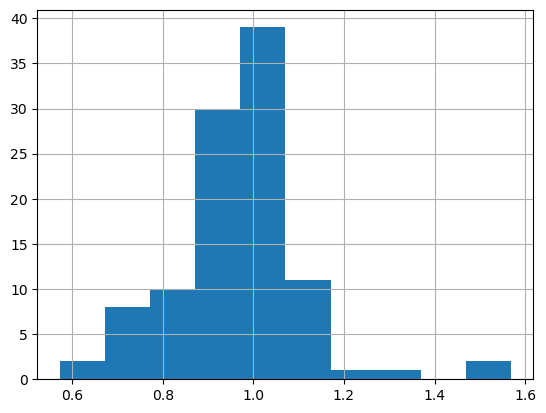

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Controleer op NaN of oneindige waarden en verwijder deze uit de kolom T5
t5_cleaned = data_clean['T5_relative'].replace([np.inf, -np.inf], np.nan).dropna()
t5_cleaned.hist()


### Simple Train / Test Split
- Hier pak ik 4 modellen, Logistic Regression, Decision tree, XGBoost en Nul model (mode) en ik train deze modellen op de test en kijk naar de nauwkeurigheid op de test set. Dit is nog zonder parameter optimalisatie. Alle modellen. Inclusief de lasso regressie lijken het slechter te doen dan de null model.
- Daarna heb ik een RFE benadering geprobeerd met dezelfde modellen
- Daarna heb ik een forward feature selection gebprobeerd

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


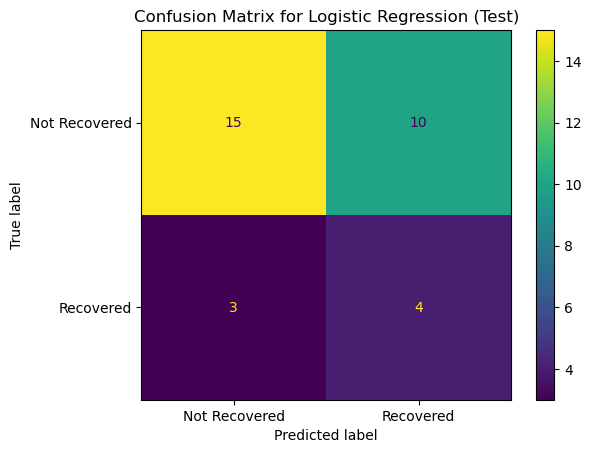

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


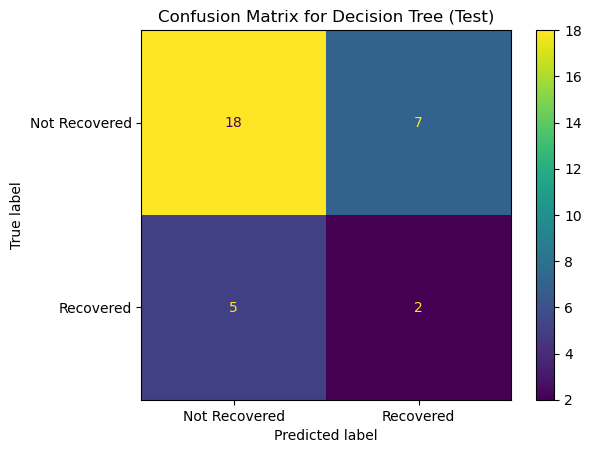

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


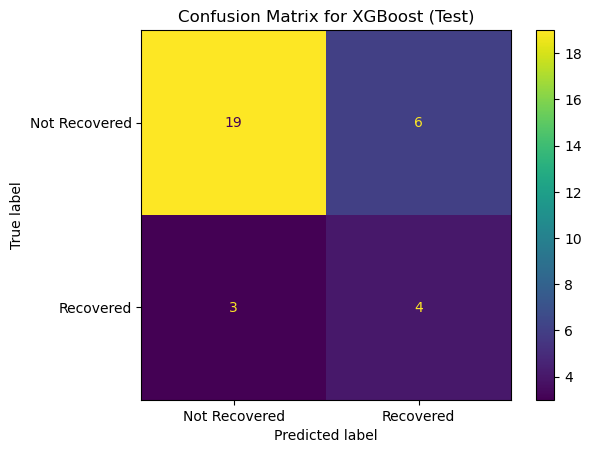

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


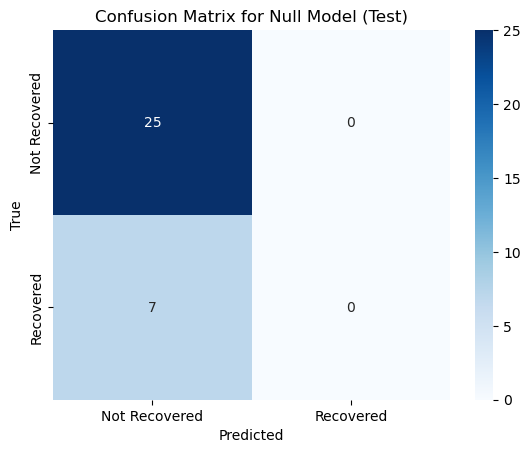

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.59375   0.285714  0.571429         0.60   
1        Decision Tree    Test   0.62500   0.222222  0.285714         0.72   
2              XGBoost    Test   0.71875   0.400000  0.571429         0.76   
3           Null Model    Test   0.78125   0.000000  0.000000         1.00   

         F1  
0  0.380952  
1  0.250000  
2  0.470588  
3  0.000000  


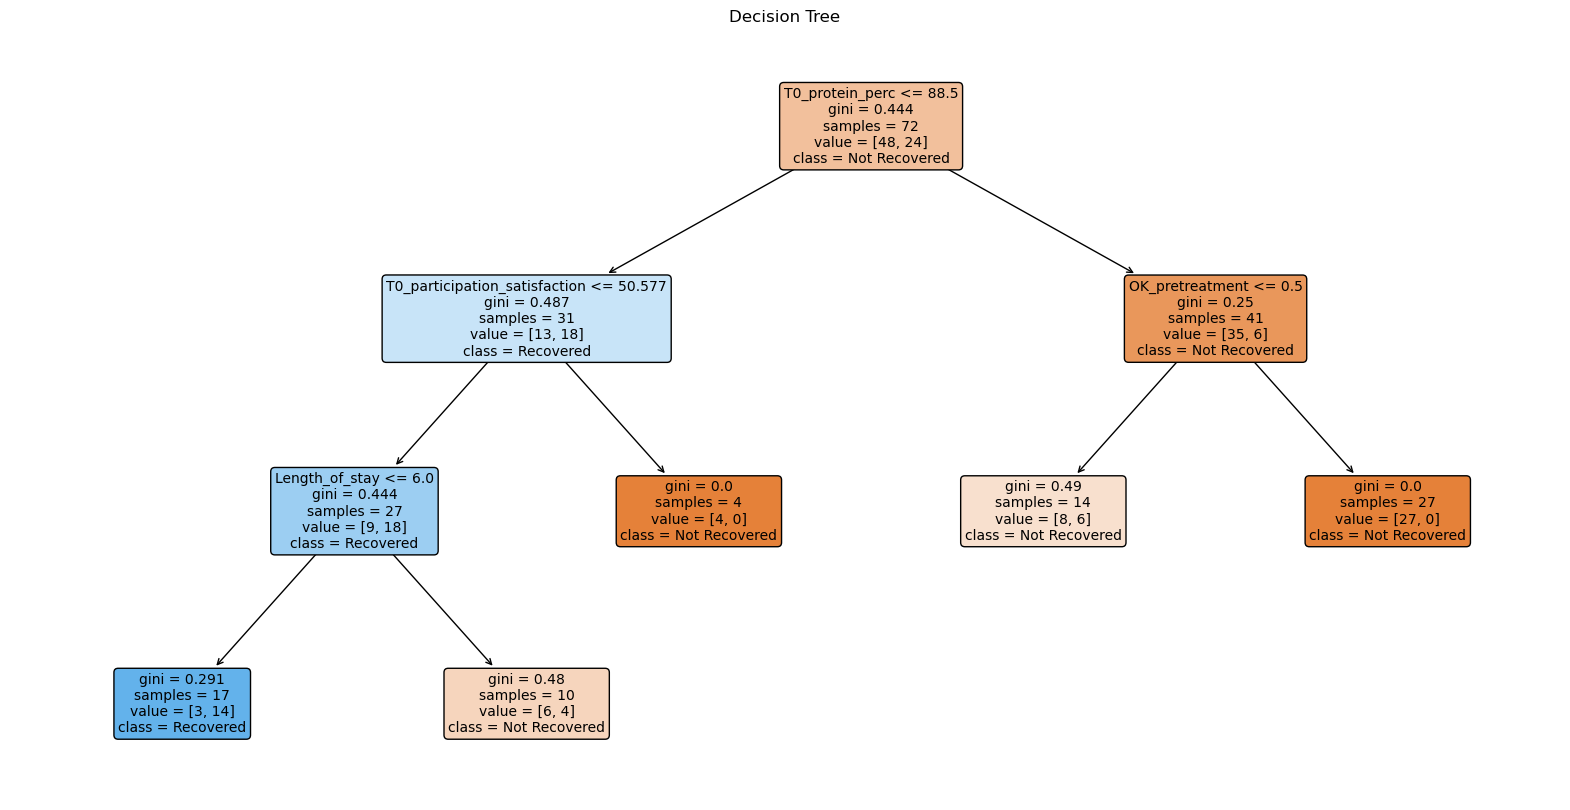

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered', 'T5_more_than_45', 'T5_relativebin'])
y = data_clean['T5_recovered']

# Maak een train/test split met 70% train en 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Functie om de metrics te berekenen
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Initialize and train models
# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)

# Decision Tree with max_leaf_nodes to reduce overfitting
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
tree_model.fit(X_train, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
y_test_pred = log_reg.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
y_test_pred = tree_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
y_test_pred = xgb_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


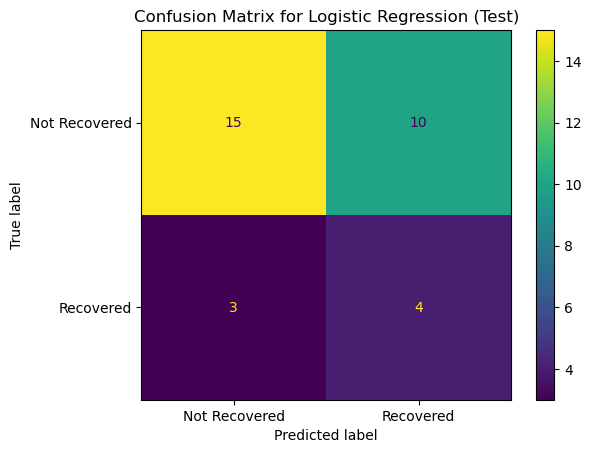

                                   Feature  Coefficient Direction
14                         OK_pretreatment    -1.601488  Negative
5                                household    -0.766308  Negative
8                                   T0_ASA    -0.726657  Negative
41                          T0_anxiety_cat     0.716609  Positive
20                    Complications_severe     0.673326  Positive
24                        OK_posttreatment    -0.624406  Negative
39           T0_participation_satisfaction    -0.535655  Negative
21                            AMEXO_8_day1     0.487891  Positive
9                     T0_diseaseburden_cat    -0.485801  Negative
0                                 pat_sexe    -0.476579  Negative
4                                Education    -0.415664  Negative
18                           Complications     0.371249  Positive
16                            OK_Technique     0.371214  Positive
42                       T0_depression_cat    -0.280451  Negative
11        

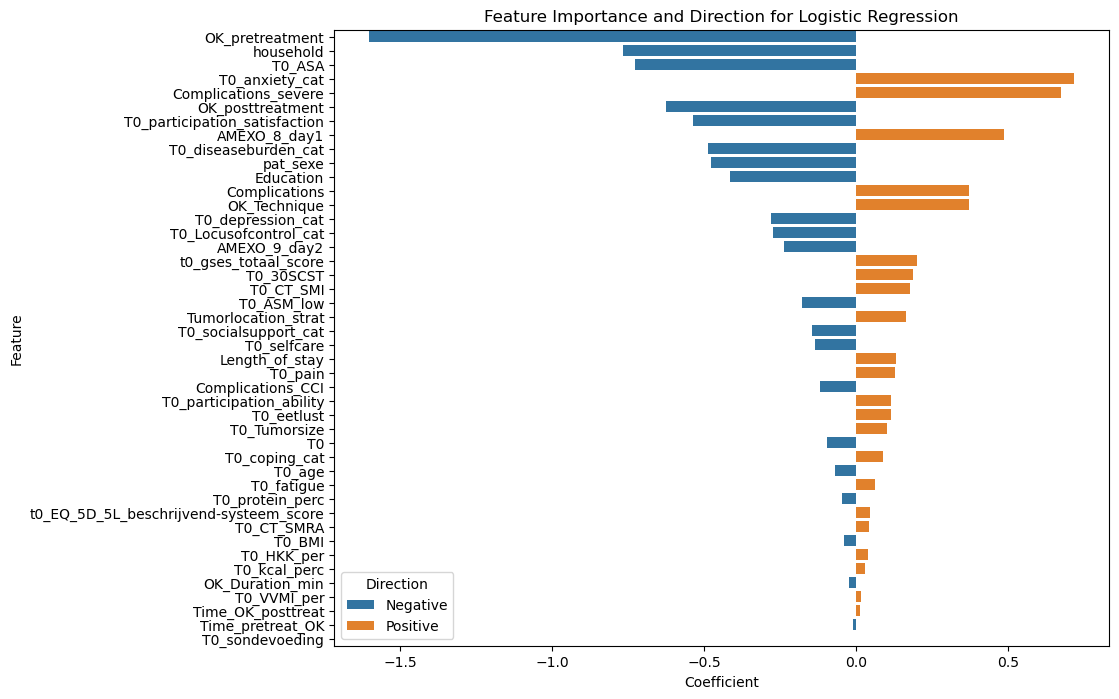

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


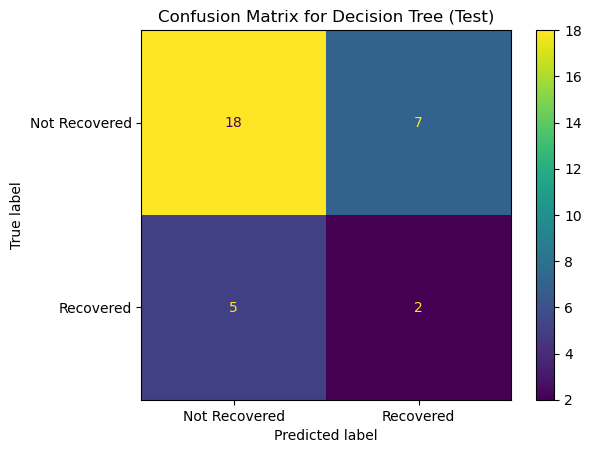

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


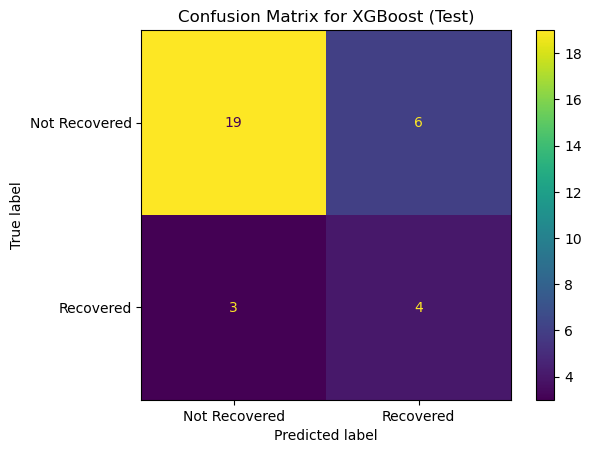

                                   Feature  Importance
31                         T0_protein_perc    0.105300
7                             T0_Tumorsize    0.098785
39           T0_participation_satisfaction    0.072376
23                          Length_of_stay    0.067255
18                           Complications    0.064862
14                         OK_pretreatment    0.051225
5                                household    0.046978
21                            AMEXO_8_day1    0.043104
32                            T0_kcal_perc    0.040303
30                              T0_HKK_per    0.039263
27                               T0_30SCST    0.039048
6                      Tumorlocation_strat    0.038128
28                                 T0_pain    0.036567
17                         OK_Duration_min    0.029349
34                               T0_CT_SMI    0.028796
43                                      T0    0.026780
16                            OK_Technique    0.026408
2         

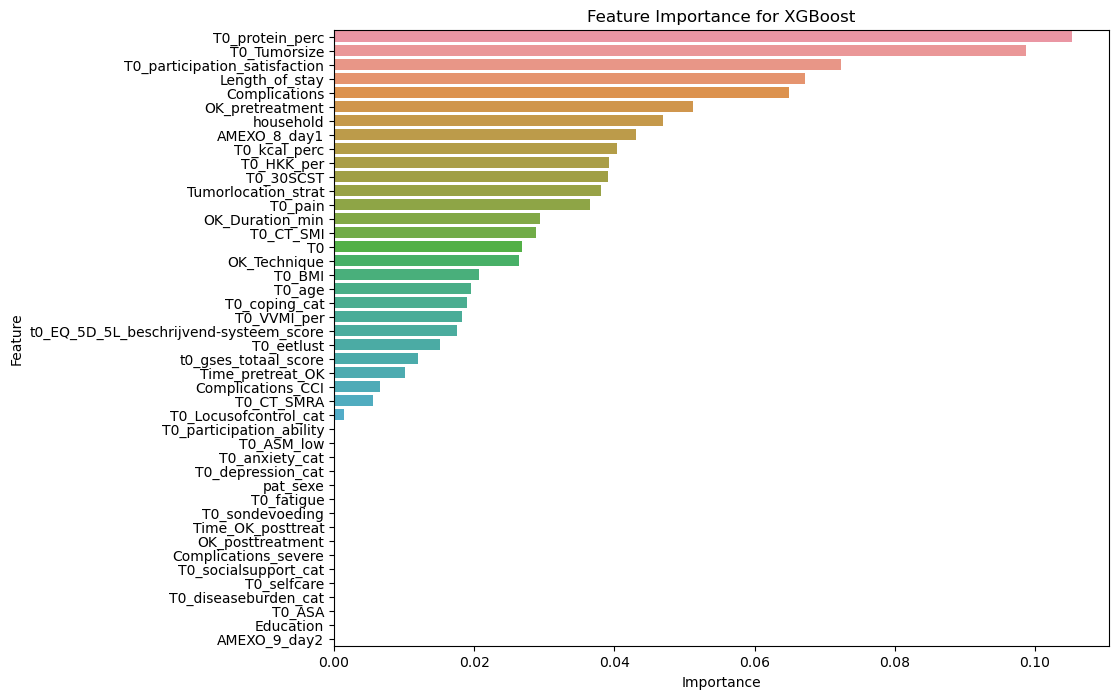

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


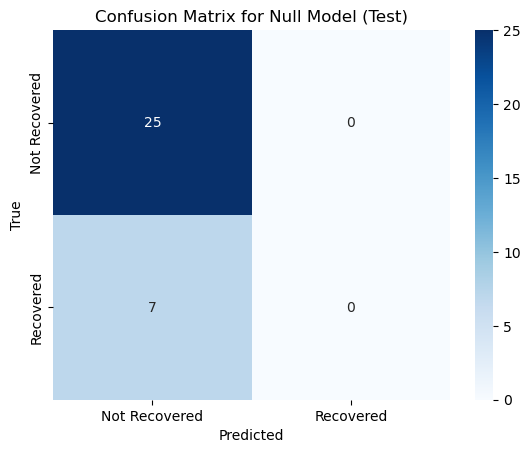

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.59375   0.285714  0.571429         0.60   
1        Decision Tree    Test   0.62500   0.222222  0.285714         0.72   
2              XGBoost    Test   0.71875   0.400000  0.571429         0.76   
3           Null Model    Test   0.78125   0.000000  0.000000         1.00   

         F1  
0  0.380952  
1  0.250000  
2  0.470588  
3  0.000000  


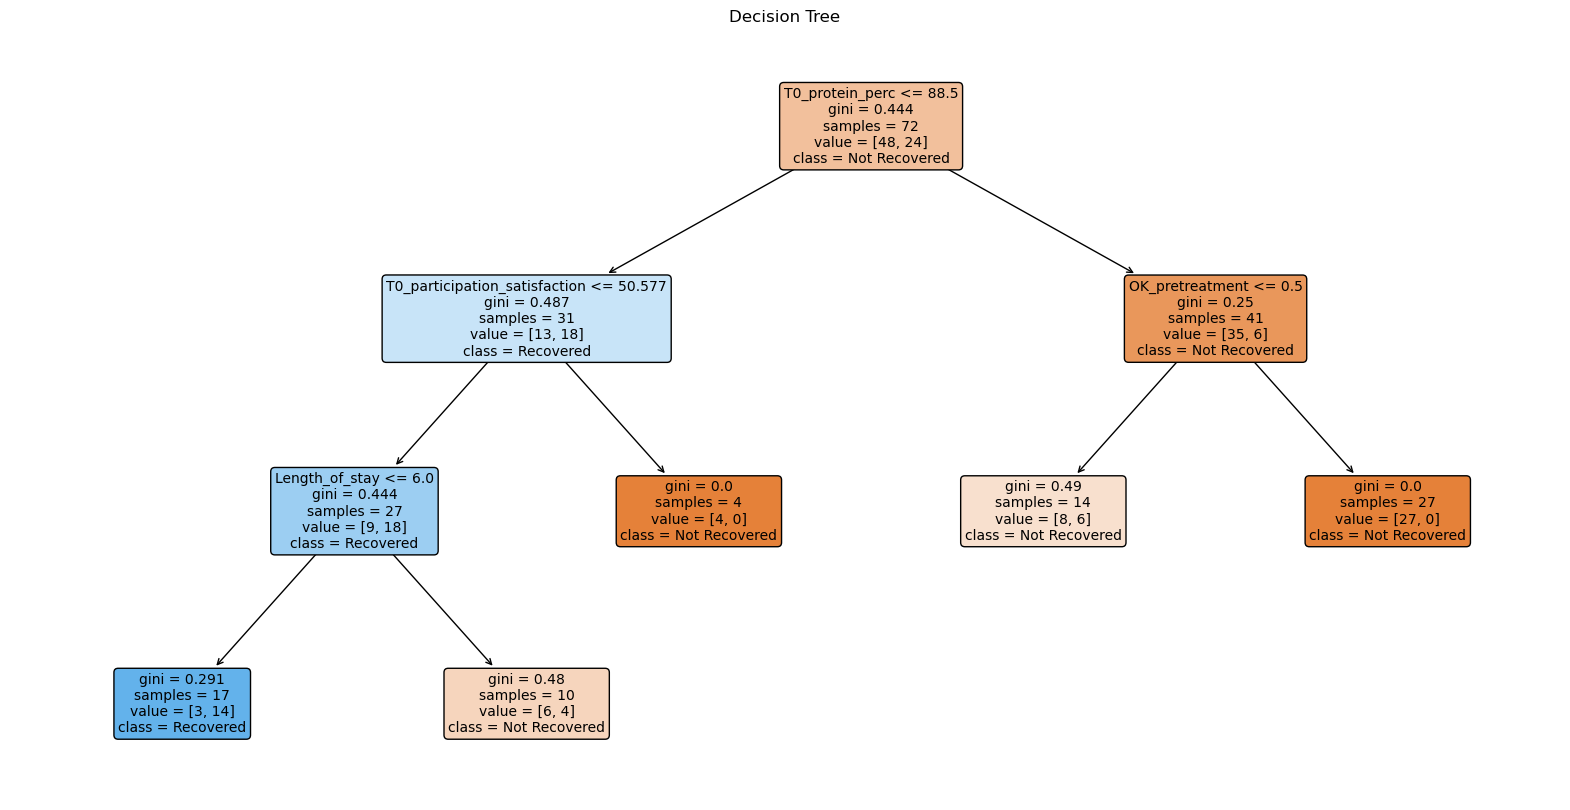

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered', 'T5_more_than_45', 'T5_relativebin'])
y = data_clean['T5_recovered']

# Make a train/test split with 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Initialize and train models
# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)

# Decision Tree with max_leaf_nodes to reduce overfitting
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
tree_model.fit(X_train, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
y_test_pred = log_reg.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Display feature importance and direction for Logistic Regression
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
coefficients['Direction'] = coefficients['Coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
coefficients = coefficients.sort_values(by='Coefficient', key=abs, ascending=False)
print(coefficients)

# Plot feature importance for Logistic Regression
plt.figure(figsize=(10, 8))
sns.barplot(data=coefficients, x='Coefficient', y='Feature', hue='Direction', dodge=False)
plt.title('Feature Importance and Direction for Logistic Regression')
plt.show()

# Decision Tree
y_test_pred = tree_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
y_test_pred = xgb_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Display feature importance for XGBoost
xgb_importances = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_})
xgb_importances = xgb_importances.sort_values(by='Importance', ascending=False)
print(xgb_importances)

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 8))
sns.barplot(data=xgb_importances, x='Importance', y='Feature')
plt.title('Feature Importance for XGBoost')
plt.show()

# Null Model
y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


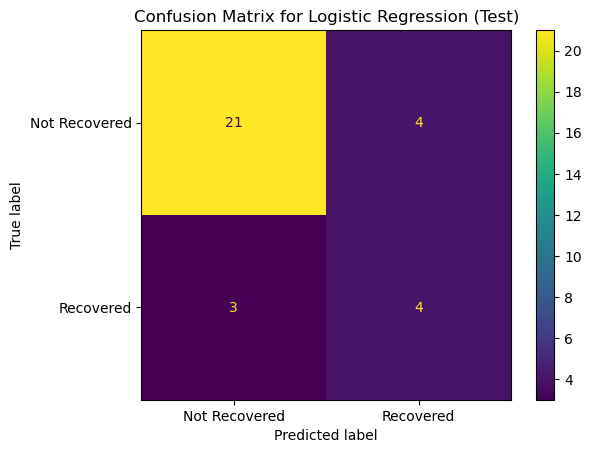

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


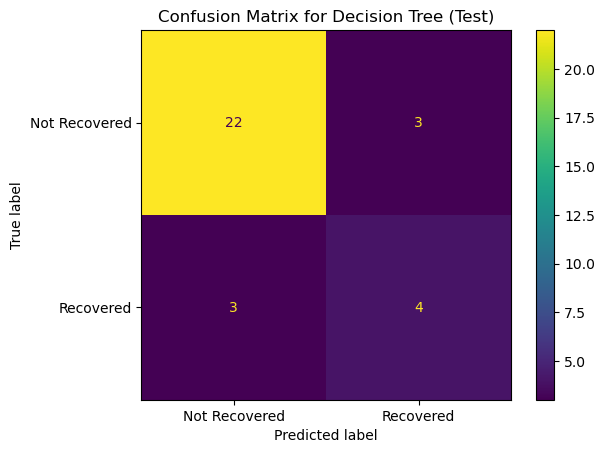

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


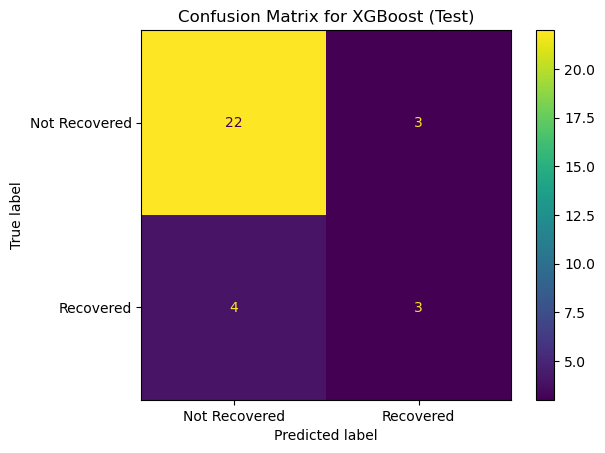

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


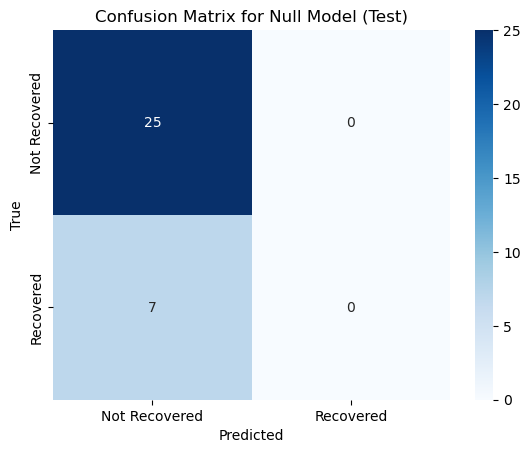

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.78125   0.500000  0.571429         0.84   
1        Decision Tree    Test   0.81250   0.571429  0.571429         0.88   
2              XGBoost    Test   0.78125   0.500000  0.428571         0.88   
3           Null Model    Test   0.78125   0.000000  0.000000         1.00   

         F1  
0  0.533333  
1  0.571429  
2  0.461538  
3  0.000000  


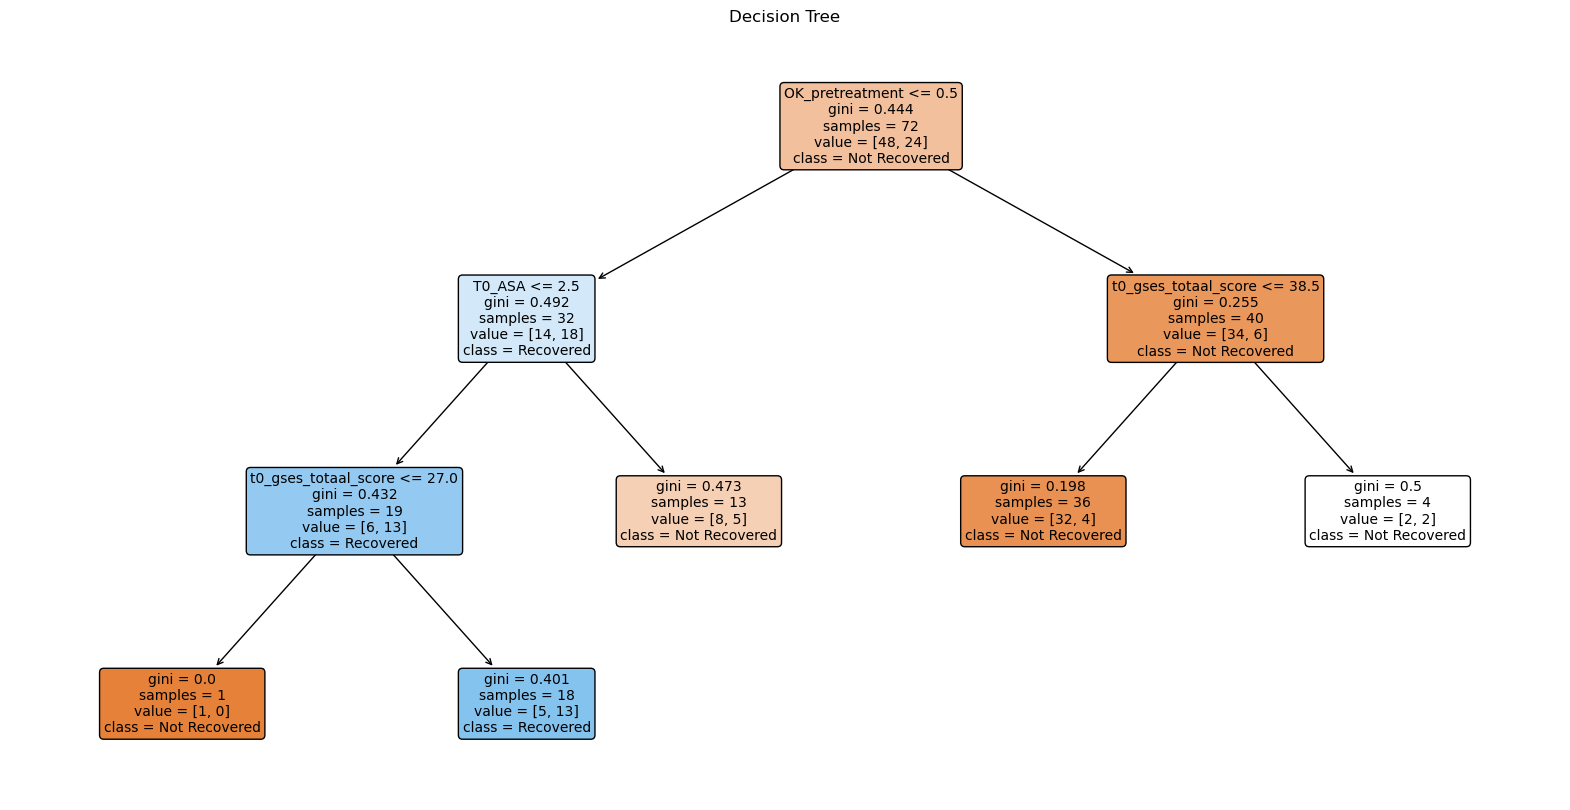

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered', 'T5_more_than_45', 'T5_relativebin'])
y = data_clean['T5_recovered']

# Maak een train/test split met 70% train en 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Recursive Feature Elimination (RFE) with Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
rfe = RFE(log_reg, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Functie om de metrics te berekenen
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Initialize and train models using the reduced feature set
# Logistic Regression
log_reg.fit(X_train_rfe, y_train)

# Decision Tree with max_leaf_nodes to reduce overfitting
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
tree_model.fit(X_train_rfe, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_rfe, y_train)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train_rfe, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
y_test_pred = log_reg.predict(X_test_rfe)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test_rfe, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
y_test_pred = tree_model.predict(X_test_rfe)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test_rfe, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
y_test_pred = xgb_model.predict(X_test_rfe)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test_rfe, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
y_test_pred = null_model.predict(X_test_rfe)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns[rfe.get_support()], class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


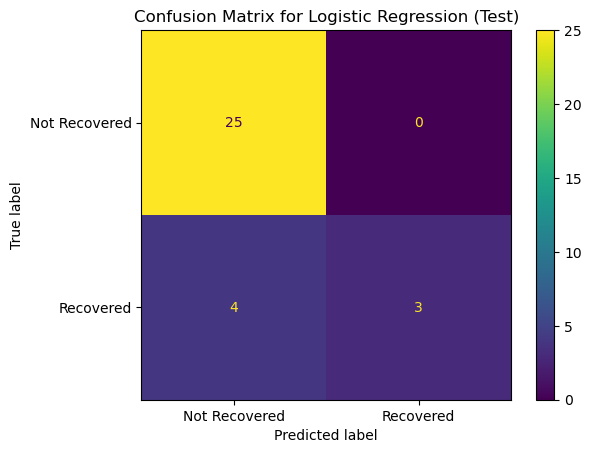

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


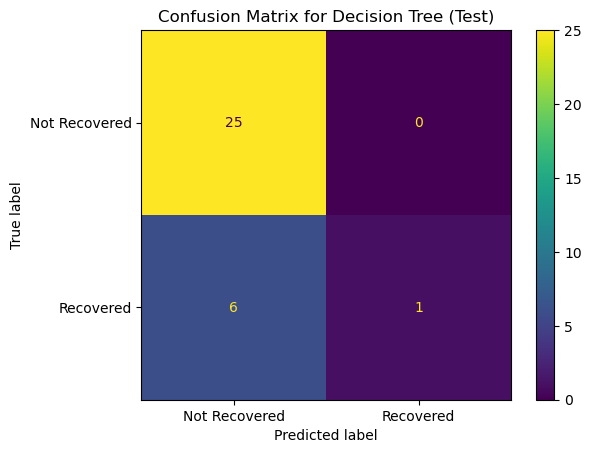

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


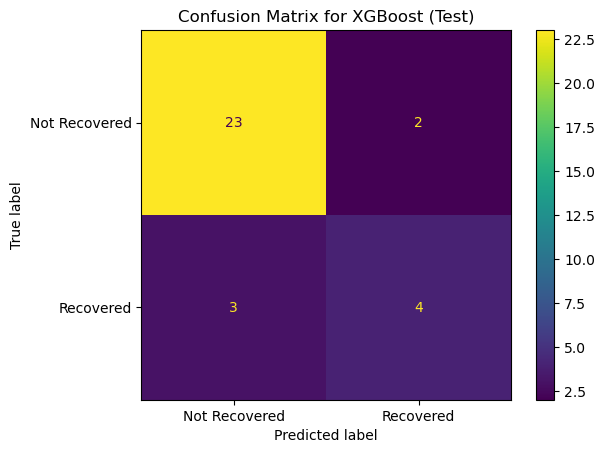

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


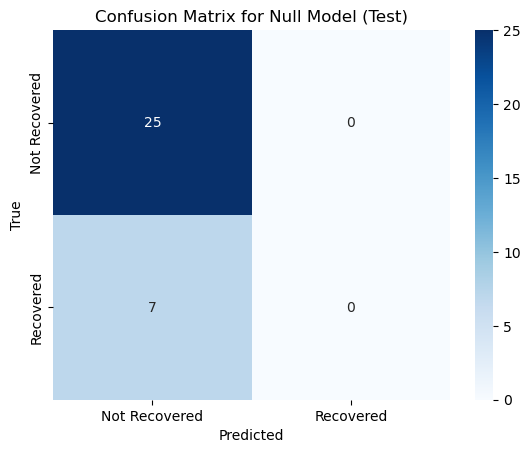

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.87500   1.000000  0.428571         1.00   
1        Decision Tree    Test   0.81250   1.000000  0.142857         1.00   
2              XGBoost    Test   0.84375   0.666667  0.571429         0.92   
3           Null Model    Test   0.78125   0.000000  0.000000         1.00   

         F1  
0  0.600000  
1  0.250000  
2  0.615385  
3  0.000000  


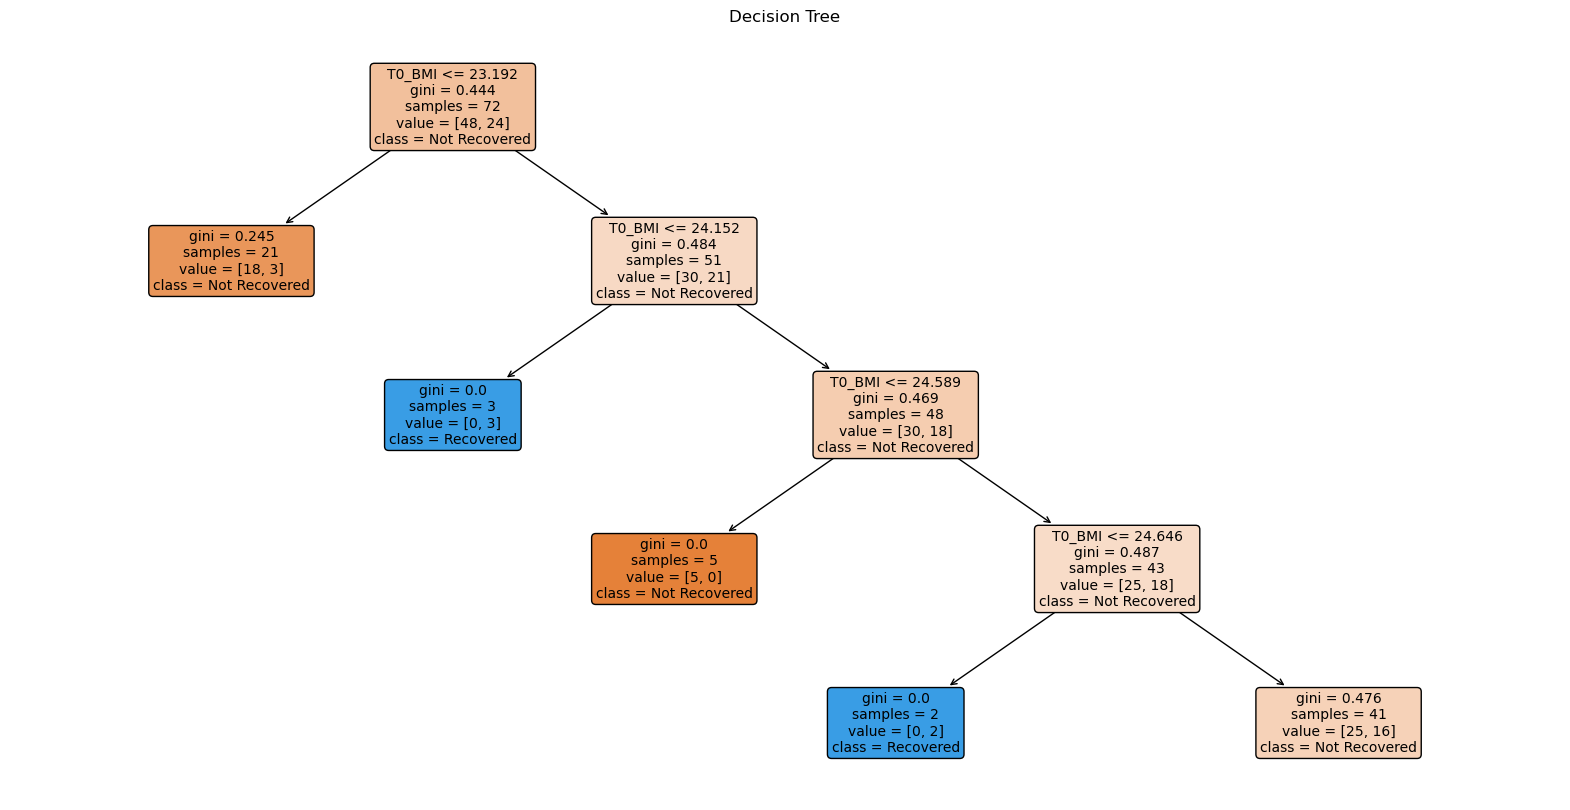

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered', 'T5_more_than_45', 'T5_relativebin'])
y = data_clean['T5_recovered']

# Maak een train/test split met 70% train en 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Functie om de metrics te berekenen
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Forward feature selection function
def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    initial_features = []
    best_features = []
    best_score = 0
    current_score = 0

    while True:
        scores = []
        for feature in X_train.columns:
            if feature in initial_features:
                continue
            selected_features = initial_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_test[selected_features])
            accuracy = accuracy_score(y_test, y_pred)
            scores.append((accuracy, feature))

        scores.sort(reverse=True)
        current_score, best_feature = scores[0]

        if current_score > best_score:
            best_score = current_score
            best_features.append(best_feature)
            initial_features.append(best_feature)
        else:
            break

    return best_features

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
best_features_log_reg = forward_feature_selection(log_reg, X_train, y_train, X_test, y_test)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
best_features_tree = forward_feature_selection(tree_model, X_train, y_train, X_test, y_test)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
best_features_xgb = forward_feature_selection(xgb_model, X_train, y_train, X_test, y_test)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
log_reg.fit(X_train[best_features_log_reg], y_train)
y_test_pred = log_reg.predict(X_test[best_features_log_reg])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test[best_features_log_reg], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
tree_model.fit(X_train[best_features_tree], y_train)
y_test_pred = tree_model.predict(X_test[best_features_tree])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test[best_features_tree], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
xgb_model.fit(X_train[best_features_xgb], y_train)
y_test_pred = xgb_model.predict(X_test[best_features_xgb])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test[best_features_xgb], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=best_features_tree, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


#### K-Fold Cross Validation - train/validation set
- Dataset wordt gesplitst in trainings- en testsets.
- Er wordt een 5-voudige cross-validatie uitgevoerd met hyperparameter tuning voor zowel Decision tree, logistic regression en xgboost
- Het beste model wordt opnieuw getraind op de volledige trainingsset en geëvalueerd op de testset, waarbij de prestaties worden gemeten met MAE, RMSE en R².
- Een null model, dat het gemiddelde van de trainingsset voorspelt, wordt gebruikt als benchmark om de prestaties van de regressiemodellen te vergelijken.

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

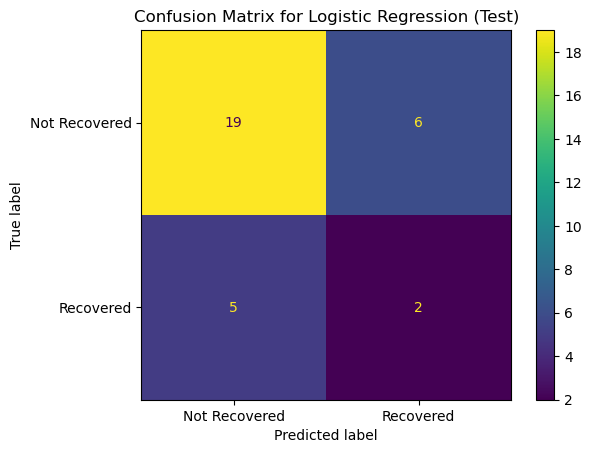

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


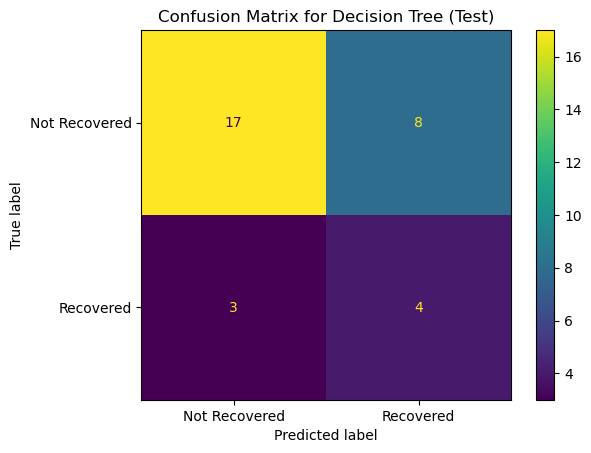

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


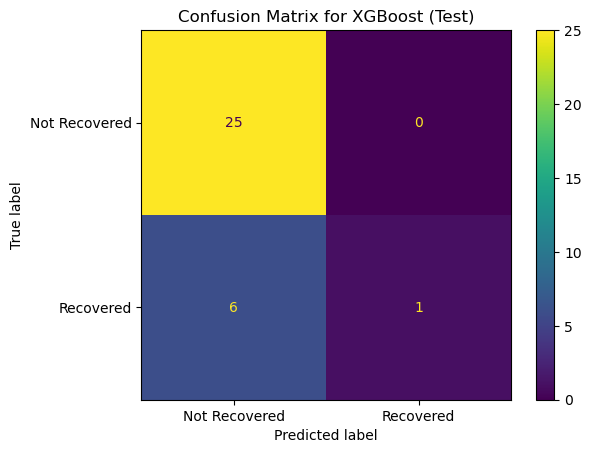

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


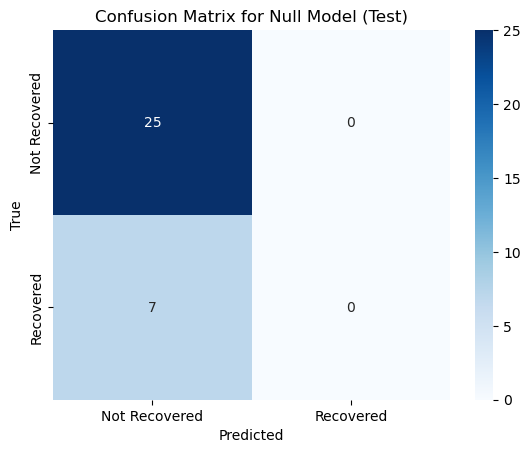

                 Model Dataset  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression    Test   0.65625   0.250000  0.285714         0.76   
1        Decision Tree    Test   0.65625   0.333333  0.571429         0.68   
2              XGBoost    Test   0.81250   1.000000  0.142857         1.00   
3           Null Model    Test   0.78125   0.000000  0.000000         1.00   

         F1  
0  0.266667  
1  0.421053  
2  0.250000  
3  0.000000  


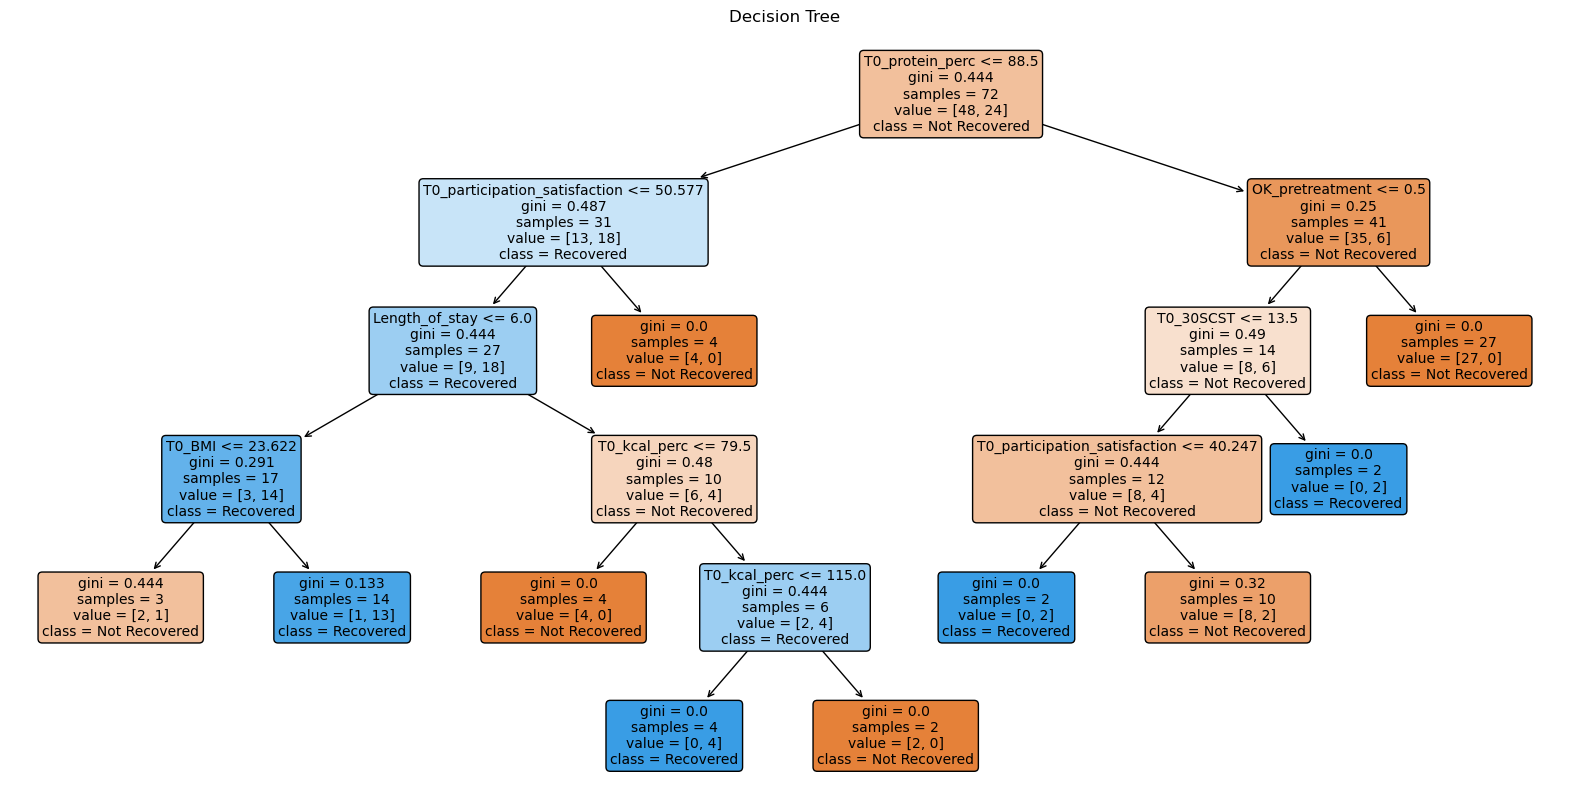

In [29]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered', 'T5_more_than_45', 'T5_relativebin'])
y = data_clean['T5_recovered']

# Maak een train/test split met 70% train en 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_params = {'max_depth': [3, 5, 7, 10], 'max_leaf_nodes': [5, 10, 20, 30]}

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
log_reg_cv = GridSearchCV(log_reg, log_reg_params, cv=kf, scoring='accuracy')
log_reg_cv.fit(X_train, y_train)

tree_cv = GridSearchCV(tree_model, tree_params, cv=kf, scoring='accuracy')
tree_cv.fit(X_train, y_train)

xgb_cv = GridSearchCV(xgb_model, xgb_params, cv=kf, scoring='accuracy')
xgb_cv.fit(X_train, y_train)

# Best estimators
best_log_reg = log_reg_cv.best_estimator_
best_tree = tree_cv.best_estimator_
best_xgb = xgb_cv.best_estimator_


# Functie om de metrics te berekenen
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Train the best models on the full training set
best_log_reg.fit(X_train, y_train)
best_tree.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
y_test_pred = best_log_reg.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_log_reg, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
y_test_pred = best_tree.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_tree, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
y_test_pred = best_xgb.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_xgb, X_test, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Null Model Evaluation
y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()


# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X.columns, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()




c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


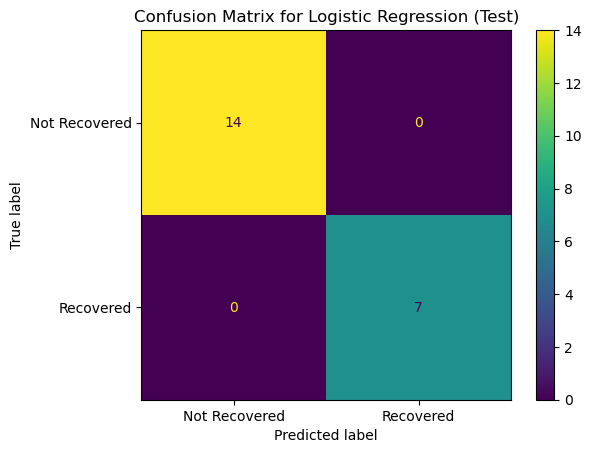

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


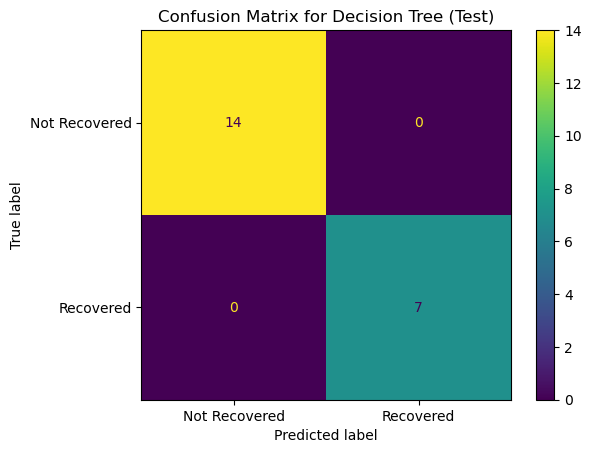

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


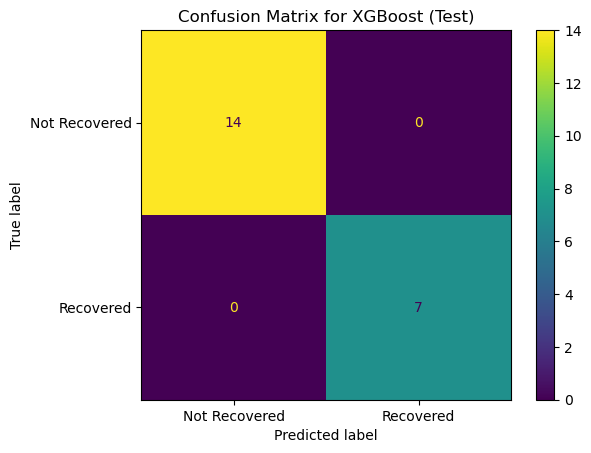

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


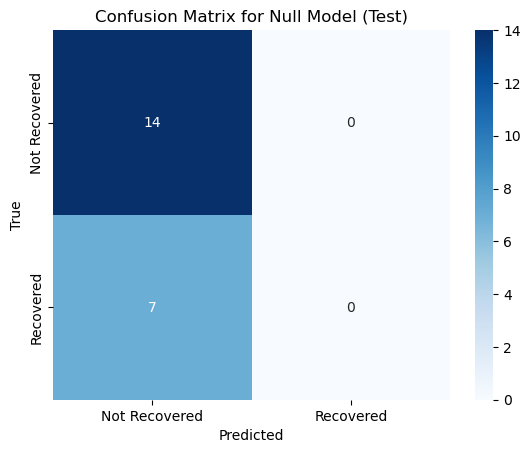

                 Model Dataset  Accuracy  Precision  Recall  Specificity   F1
0  Logistic Regression    Test  1.000000        1.0     1.0          1.0  1.0
1        Decision Tree    Test  1.000000        1.0     1.0          1.0  1.0
2              XGBoost    Test  1.000000        1.0     1.0          1.0  1.0
3           Null Model    Test  0.666667        0.0     0.0          1.0  0.0


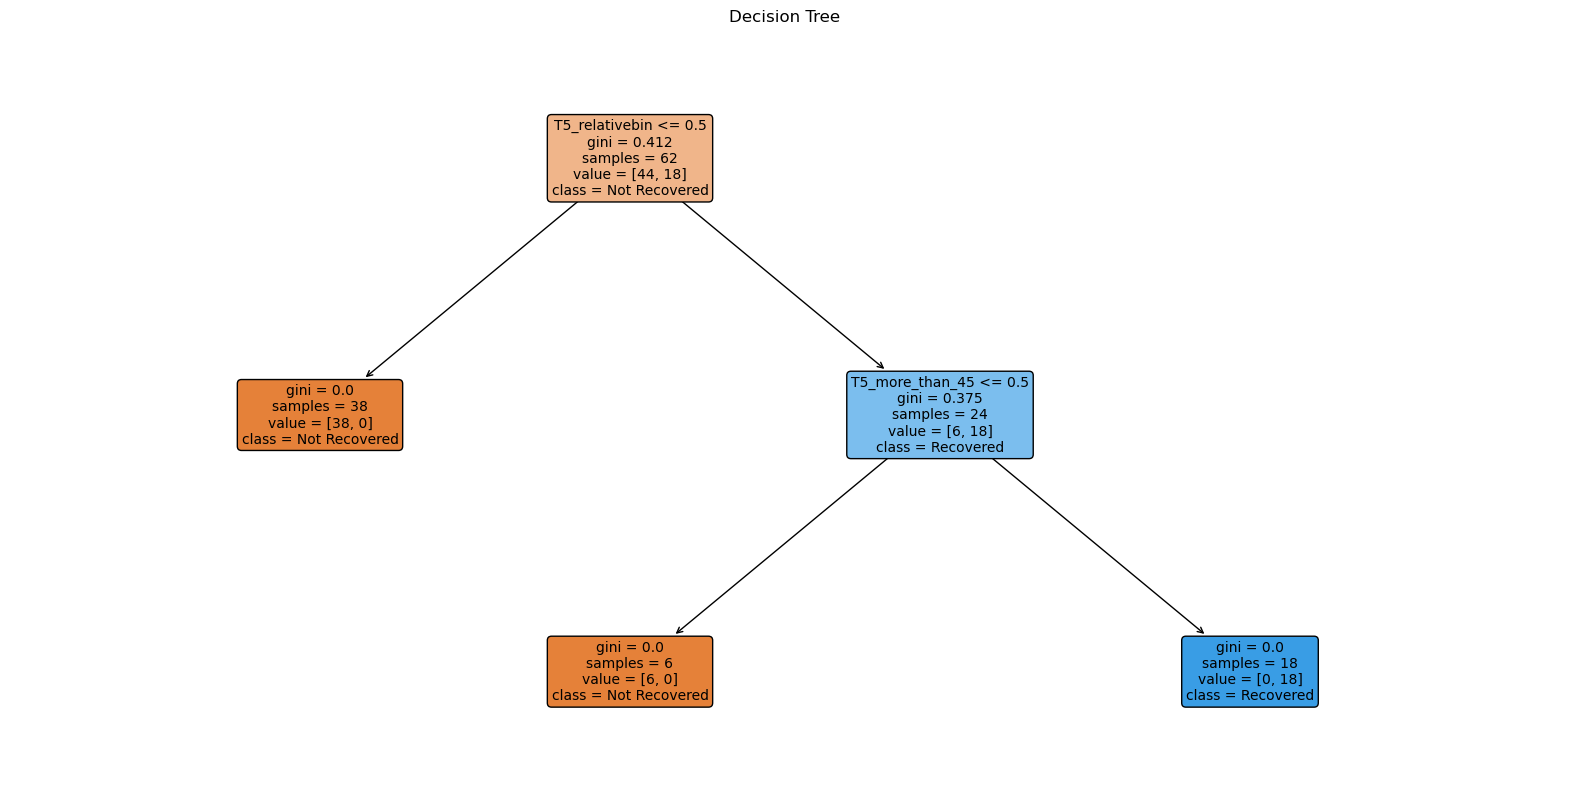

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered'])
y = data_clean['T5_recovered']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Functie om de metrics te berekenen
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Forward feature selection function
def forward_feature_selection(model, X_train, y_train, X_val, y_val):
    initial_features = []
    best_features = []
    best_score = 0
    current_score = 0

    while True:
        scores = []
        for feature in X_train.columns:
            if feature in initial_features:
                continue
            selected_features = initial_features + [feature]
            model.fit(X_train[selected_features], y_train)
            y_pred = model.predict(X_val[selected_features])
            accuracy = accuracy_score(y_val, y_pred)
            scores.append((accuracy, feature))

        scores.sort(reverse=True)
        current_score, best_feature = scores[0]

        if current_score > best_score:
            best_score = current_score
            best_features.append(best_feature)
            initial_features.append(best_feature)
        else:
            break

    return best_features

# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
best_features_log_reg = forward_feature_selection(log_reg, X_train, y_train, X_val, y_val)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
best_features_tree = forward_feature_selection(tree_model, X_train, y_train, X_val, y_val)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
best_features_xgb = forward_feature_selection(xgb_model, X_train, y_train, X_val, y_val)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
log_reg.fit(X_train[best_features_log_reg], y_train)
y_test_pred = log_reg.predict(X_test[best_features_log_reg])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test[best_features_log_reg], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
tree_model.fit(X_train[best_features_tree], y_train)
y_test_pred = tree_model.predict(X_test[best_features_tree])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test[best_features_tree], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
xgb_model.fit(X_train[best_features_xgb], y_train)
y_test_pred = xgb_model.predict(X_test[best_features_xgb])
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test[best_features_xgb], y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=best_features_tree, class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


### Dimensionality Reduction - PCA
Leidt tot een significante prestatiereductie

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered'])
y = data_clean['T5_recovered']

# Perform PCA on the input features to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Initialize models
log_reg = LogisticRegression(max_iter=10000)
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Apply RFE to select the most important features
rfe_log_reg = RFE(log_reg, n_features_to_select=10)
X_train_rfe_log_reg = rfe_log_reg.fit_transform(X_train, y_train)
X_test_rfe_log_reg = rfe_log_reg.transform(X_test)

rfe_tree = RFE(tree_model, n_features_to_select=10)
X_train_rfe_tree = rfe_tree.fit_transform(X_train, y_train)
X_test_rfe_tree = rfe_tree.transform(X_test)

rfe_xgb = RFE(xgb_model, n_features_to_select=10)
X_train_rfe_xgb = rfe_xgb.fit_transform(X_train, y_train)
X_test_rfe_xgb = rfe_xgb.transform(X_test)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
log_reg.fit(X_train_rfe_log_reg, y_train)
y_test_pred = log_reg.predict(X_test_rfe_log_reg)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(log_reg, X_test_rfe_log_reg, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
tree_model.fit(X_train_rfe_tree, y_train)
y_test_pred = tree_model.predict(X_test_rfe_tree)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(tree_model, X_test_rfe_tree, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
xgb_model.fit(X_train_rfe_xgb, y_train)
y_test_pred = xgb_model.predict(X_test_rfe_xgb)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_test_rfe_xgb, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
# Since RFE was applied to PCA components, we can just display the component indices
plot_tree(tree_model, feature_names=[f'PCA{i+1}' for i in range(X_train_rfe_tree.shape[1])], class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered'])
y = data_clean['T5_recovered']

# Split the data into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

# Perform PCA on the training set and apply the transformation to the validation and test sets
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Initialize models
log_reg = LogisticRegression(max_iter=10000)
tree_model = DecisionTreeClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning using GridSearchCV with k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression hyperparameters
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_cv = GridSearchCV(log_reg, log_reg_params, cv=kf, scoring='accuracy')
log_reg_cv.fit(X_train_pca, y_train)
best_log_reg = log_reg_cv.best_estimator_

# Decision Tree hyperparameters
tree_params = {'max_depth': [3, 5, 7, 10], 'max_leaf_nodes': [5, 10, 20, 30]}
tree_cv = GridSearchCV(tree_model, tree_params, cv=kf, scoring='accuracy')
tree_cv.fit(X_train_pca, y_train)
best_tree = tree_cv.best_estimator_

# XGBoost hyperparameters
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
xgb_cv = GridSearchCV(xgb_model, xgb_params, cv=kf, scoring='accuracy')
xgb_cv.fit(X_train_pca, y_train)
best_xgb = xgb_cv.best_estimator_

# Apply RFE to select the most important features
rfe_log_reg = RFE(best_log_reg, n_features_to_select=10)
X_train_rfe_log_reg = rfe_log_reg.fit_transform(X_train_pca, y_train)
X_val_rfe_log_reg = rfe_log_reg.transform(X_val_pca)
X_test_rfe_log_reg = rfe_log_reg.transform(X_test_pca)

rfe_tree = RFE(best_tree, n_features_to_select=10)
X_train_rfe_tree = rfe_tree.fit_transform(X_train_pca, y_train)
X_val_rfe_tree = rfe_tree.transform(X_val_pca)
X_test_rfe_tree = rfe_tree.transform(X_test_pca)

rfe_xgb = RFE(best_xgb, n_features_to_select=10)
X_train_rfe_xgb = rfe_xgb.fit_transform(X_train_pca, y_train)
X_val_rfe_xgb = rfe_xgb.transform(X_val_pca)
X_test_rfe_xgb = rfe_xgb.transform(X_test_pca)

# Train the best models using the selected features
best_log_reg.fit(X_train_rfe_log_reg, y_train)
best_tree.fit(X_train_rfe_tree, y_train)
best_xgb.fit(X_train_rfe_xgb, y_train)

# Evaluate models on the test set
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
y_test_pred = best_log_reg.predict(X_test_rfe_log_reg)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_log_reg, X_test_rfe_log_reg, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
y_test_pred = best_tree.predict(X_test_rfe_tree)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_tree, X_test_rfe_tree, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
y_test_pred = best_xgb.predict(X_test_rfe_xgb)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_xgb, X_test_rfe_xgb, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train_pca, y_train)

y_test_pred = null_model.predict(X_test_pca)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
# Since RFE was applied to PCA components, we can just display the component indices
plot_tree(best_tree, feature_names=[f'PCA{i+1}' for i in range(X_train_rfe_tree.shape[1])], class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()


In [ ]:
################## Duurt 8 minunten ##########################

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered'])
y = data_clean['T5_recovered']

# Split the data into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, precision, recall, specificity, f1

# Initialize models
log_reg = LogisticRegression(max_iter=10000)
tree_model = DecisionTreeClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create pipelines with PCA and model
pipe_log_reg = Pipeline([('pca', PCA()), ('log_reg', log_reg)])
pipe_tree = Pipeline([('pca', PCA()), ('tree', tree_model)])
pipe_xgb = Pipeline([('pca', PCA()), ('xgb', xgb_model)])

# Hyperparameter tuning using GridSearchCV with k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression hyperparameters including PCA n_components
log_reg_params = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'log_reg__C': [0.01, 0.1, 1, 10, 100]
}
log_reg_cv = GridSearchCV(pipe_log_reg, log_reg_params, cv=kf, scoring='accuracy')
log_reg_cv.fit(X_train, y_train)
best_log_reg = log_reg_cv.best_estimator_

# Decision Tree hyperparameters including PCA n_components
tree_params = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'tree__max_depth': [3, 5, 7, 10],
    'tree__max_leaf_nodes': [5, 10, 20, 30]
}
tree_cv = GridSearchCV(pipe_tree, tree_params, cv=kf, scoring='accuracy')
tree_cv.fit(X_train, y_train)
best_tree = tree_cv.best_estimator_

# XGBoost hyperparameters including PCA n_components
xgb_params = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}
xgb_cv = GridSearchCV(pipe_xgb, xgb_params, cv=kf, scoring='accuracy')
xgb_cv.fit(X_train, y_train)
best_xgb = xgb_cv.best_estimator_

# Apply RFE to select the most important features
rfe_log_reg = RFE(best_log_reg.named_steps['log_reg'], n_features_to_select=10)
X_train_rfe_log_reg = rfe_log_reg.fit_transform(best_log_reg.named_steps['pca'].transform(X_train), y_train)
X_val_rfe_log_reg = rfe_log_reg.transform(best_log_reg.named_steps['pca'].transform(X_val))
X_test_rfe_log_reg = rfe_log_reg.transform(best_log_reg.named_steps['pca'].transform(X_test))

rfe_tree = RFE(best_tree.named_steps['tree'], n_features_to_select=10)
X_train_rfe_tree = rfe_tree.fit_transform(best_tree.named_steps['pca'].transform(X_train), y_train)
X_val_rfe_tree = rfe_tree.transform(best_tree.named_steps['pca'].transform(X_val))
X_test_rfe_tree = rfe_tree.transform(best_tree.named_steps['pca'].transform(X_test))

rfe_xgb = RFE(best_xgb.named_steps['xgb'], n_features_to_select=10)
X_train_rfe_xgb = rfe_xgb.fit_transform(best_xgb.named_steps['pca'].transform(X_train), y_train)
X_val_rfe_xgb = rfe_xgb.transform(best_xgb.named_steps['pca'].transform(X_val))
X_test_rfe_xgb = rfe_xgb.transform(best_xgb.named_steps['pca'].transform(X_test))

# Train the best models using the selected features
best_log_reg.named_steps['log_reg'].fit(X_train_rfe_log_reg, y_train)
best_tree.named_steps['tree'].fit(X_train_rfe_tree, y_train)
best_xgb.named_steps['xgb'].fit(X_train_rfe_xgb, y_train)

# Evaluate models on the test set
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1': []
}

# Logistic Regression
y_test_pred = best_log_reg.named_steps['log_reg'].predict(X_test_rfe_log_reg)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Logistic Regression')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_log_reg.named_steps['log_reg'], X_test_rfe_log_reg, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Logistic Regression (Test)')
plt.show()

# Decision Tree
y_test_pred = best_tree.named_steps['tree'].predict(X_test_rfe_tree)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Decision Tree')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_tree.named_steps['tree'], X_test_rfe_tree, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for Decision Tree (Test)')
plt.show()

# XGBoost
y_test_pred = best_xgb.named_steps['xgb'].predict(X_test_rfe_xgb)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('XGBoost')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
plot_confusion_matrix(best_xgb.named_steps['xgb'], X_test_rfe_xgb, y_test, display_labels=['Not Recovered', 'Recovered'])
plt.title('Confusion Matrix for XGBoost (Test)')
plt.show()

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode()[0]
    def predict(self, X):
        return np.full(len(X), self.mode)

null_model = NullModel()
null_model.fit(X_train, y_train)

y_test_pred = null_model.predict(X_test)
accuracy, precision, recall, specificity, f1 = calculate_metrics(y_test, y_test_pred)
metrics['Model'].append('Null Model')
metrics['Dataset'].append('Test')
metrics['Accuracy'].append(accuracy)
metrics['Precision'].append(precision)
metrics['Recall'].append(recall)
metrics['Specificity'].append(specificity)
metrics['F1'].append(f1)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set(xlabel='Predicted', ylabel='True', title='Confusion Matrix for Null Model (Test)')
ax.set_xticklabels(['Not Recovered', 'Recovered'])
ax.set_yticklabels(['Not Recovered', 'Recovered'])
plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
# Since RFE was applied to PCA components, we can just display the component indices
plot_tree(best_tree.named_steps['tree'], feature_names=[f'PCA{i+1}' for i in range(X_train_rfe_tree.shape[1])], class_names=['Not Recovered', 'Recovered'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree')
plt.show()
